# Example code for maximum information rate autonomous experimentation algorithm
David P. Hoogerheide, May 2022

## Initial setup section

In this section, various funtions are defined and the initial problem is set up. The ground truth curve is calculated and an initial (unconstrained) MCMC fit is performed.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from bumps.names import Parameter, Curve, FitProblem

# define function (10th-order polynomial)

def poly(x, p0, p1, p2, p3, p4, p5, p6, p7, p8, p9):

    coeff = [p0, p1, p2, p3, p4, p5, p6, p7, p8, p9]

    return np.polyval(coeff, x)


In [2]:
def calc_entropy(pts, select_pars=None):
    """Function for calculating MVN (multivariate normal) entropy

        Inputs:
        pts -- N (number of samples) x P (number of parameters) array, e.g. from MCMCDraw.points
        select_pars -- if None, all parameters are used; otherwise a list or array of parameter indices to use
                        for marginalization

        Returns:
        H -- MVN entropy (marginalized if select_pars is not None) of pts

    """
    npar = len(pts[0,:])

    if select_pars is None:
        sel = np.arange(npar)
    else:
        sel = np.array(select_pars)

    pts = pts[:,sel]

    npar = len(sel)

    covX = np.cov(pts.T)

    # protects against single selected parameters that give zero-dimension covX
    covX = np.array(covX, ndmin=2)

    H = 0.5 * npar * (np.log(2 * np.pi) + 1) + np.linalg.slogdet(covX)[1]
    return H

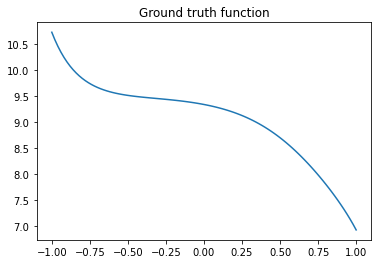

In [3]:
"""Define a model function for generating new points

    calcproblem -- the Bumps FitProblem object containing the ground truth model

"""

npars = 10
#truepars = 2 * (0.5 - np.random.rand(npars))

truepars = np.array([-0.60450577, -0.07219354,  0.63737837,  0.79540074, -0.44733873,
       -0.34335843, -0.92088505, -0.89051561, -0.56249188,  9.34154348 - 10])
truepars[-1] +=10.0 # ensures that all function values are positive

p = list()
for i in range(npars):
    p.append(Parameter(name=f'p{i}', value=0.0).range(-1., 1.))

x = np.linspace(-1, 1, 101)
ix = np.linspace(-1, 1, npars + 1)

truey = poly(x, *truepars)
plt.plot(x, truey)
plt.title('Ground truth function')

modely = Curve(poly, ix, np.ones_like(ix), dy=np.ones_like(ix), p0=p[0], p1=p[1], p2=p[2], p3=p[3], p4=p[4], p5=p[5], p6=p[6], p7=p[7], p8=p[8], p9=p[9] + 10.)
calcproblem = FitProblem(modely)


In [4]:
def sampler(problem, x, pts):
    """ Function for generating y(x) curves from MCMC samples
    
        Inputs:
        problem -- FitProblem object containing the theory curve
        x -- the function space, with dimension X
        pts -- list or array of MCMC samples (i.e. parameter vectors), dimension N (number of samples) x P (number of parameters)

        Returns:
        ys -- an N x X array containing y(x) for each MCMC sample
    """
    
    ys = list()
    for v in pts:
        # set the parameters
        problem.setp(v)

        # calling chisq_str updates the model
        problem.chisq_str()

        # calculate the updated theory curve
        y = problem.fitness.theory(x)
        ys.append(y)

    return np.array(ys)


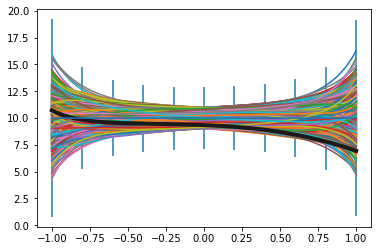

In [5]:
"""
Generate an initial set of data points equal to number of parameters + 1. Error bars on initial points are very large so as not to constrain the initial fit.
"""

from bumps.initpop import generate

problem = FitProblem(modely)

ipop = generate(problem, init='lhs', pop=100)
plt.figure()
ys = sampler(problem, x, ipop)
for y in ys:
    plt.plot(x, y)
plt.plot(x, truey, linewidth=4, color='0.1')

inity = np.interp(ix, x, np.mean(ys, axis=0))
initdy = 5 * np.interp(ix, x, np.std(ys, axis=0))

plt.errorbar(ix, inity, initdy)

newmodely = Curve(poly, ix, inity, initdy, p0=p[0], p1=p[1], p2=p[2], p3=p[3], p4=p[4], p5=p[5], p6=p[6], p7=p[7], p8=p[8], p9=p[9] + 10.)
problem = FitProblem(newmodely)



In [6]:
""" Set up and run the initial fit"""

from bumps.fitters import DreamFit, ConsoleMonitor

monitor = ConsoleMonitor(problem)

# Condition and run fit
fitter = DreamFit(problem)
result = fitter.solve(monitors=[monitor], options={'burn': 1000, 'steps': 100, 'pop': 10})


# steps: 100, # draws: 10000
step 1 cost 0.000(12)e3
                                      p0 ....|..... -0.00033181 in (-1,1)
                                      p1 .......|..   0.528769 in (-1,1)
                                      p2 ....|..... -0.0575611 in (-1,1)
                                      p3 ......|...   0.284613 in (-1,1)
                                      p4 ....|.....  -0.158588 in (-1,1)
                                      p5 ......|...   0.225336 in (-1,1)
                                      p6 ..|.......  -0.413638 in (-1,1)
                                      p7 ........|.   0.665979 in (-1,1)
                                      p8 |.........  -0.943546 in (-1,1)
                                      p9 .....|....  0.0398417 in (-1,1)
step 9 cost 0.000(12)e3
step 42 cost 0.000(12)e3
step 84 cost 0.000(12)e3
step 126 cost 0.000(12)e3
step 146 cost 0.000(12)e3


In [7]:
from autorefl import calc_entropy
from bumps.dream.stats import credible_interval

def dH(xs, yprofs, pts, sel=None):
    """ Function for calculating the figure of merit based on the change in information (\DeltaH)
    
        Inputs:
        xs -- function space (dimension X)
        yprofs -- y(x) array, e.g. from "sampler", dimension N (number of samples) x X
        pts -- MCMC samples, dimension N x P (number of parameters)
        sel -- if None, all parameters are used; otherwise an array of parameters of interest for marginalization

        Returns:
        dH -- array (dimension X) of \DeltaH for each x in the function space
        relsig -- relative error at each point in the function space (not generally useful, only used for this example)

    """

    H0 = calc_entropy(pts, select_pars=sel)
    dH = list()
    relsig = list()

    # step through function space and calculate dH at each point. Note that this can be done more efficiently with
    # np.argsort over the entire xs space.
    for idx, x in enumerate(xs):
        iqs = yprofs[:,idx]
        iqs_sorted = np.sort(iqs)
        
        # calculate median and CI. This can be done more efficiently and over the whole xs array with np.argsort
        med, ci = credible_interval(iqs_sorted, (0, 0.68))
        med = med[0]
        eff_sigma = 0.5 * np.diff(ci)[0]

        # for now assume this (fairly standard) relationship between the error and the measurement time. In a real
        # experiment there is a rate scaling factor
        meastime = 1./eff_sigma**2

        # select points in the CI and calculate the entropy of selected points
        crit = (iqs > ci[0]) & (iqs < ci[1])
        #r1idxs = np.arange(len(crit))[crit]
        iH = calc_entropy(pts[crit, :], select_pars=sel)

        # calculate dH/dt and relative error
        dH.append((H0 - iH) / meastime)
        relsig.append(eff_sigma / med)

    return np.array(dH), np.array(relsig)


In [8]:
# initialize data variables
datax = [ix]
datay = [inity]
datady = [initdy]
iternum = -1

In [9]:
def new_points(newx, x, truey, dyoy=0.1):
    """ Function for generating new data points

        Inputs:
        newx -- x position of new data point(s)
        x -- function space
        truey -- ground truth function values
        dyoy -- target \Deltay / y for the new data points

        Returns:
        newy -- y(newx): function values
        newdy -- dy(newx): function uncertainties
    
    """

    newy = np.interp(newx, x, truey)
    newdy = np.abs(dyoy * newy)
    newy += newdy * np.random.randn(*newdy.shape)

    return newy, newdy

def flatten(a):
    """ Super flatten"""

    return np.array([ia for alist in a for ia in alist])



## Iteration section

Each iteration can be performed by running all cells in the following section. The algorithm is:
1. Draw MCMC samples from the previous fit result
2. Calculate y(x) corresponding to each sample
3. Calculate dH/dt(x) as the figure of merit. Note that "speed improvement factor" is over a randomly selected point.
4. Select a new point
5. Simulate data at the new point
6. Run MCMC fit

In [25]:
# increment iteration counter
iternum += 1

Expected speed improvement factor:  3.25


Text(0.5, 0, 'Parameter number')

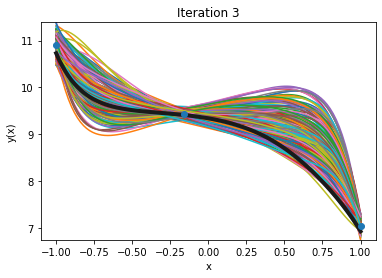

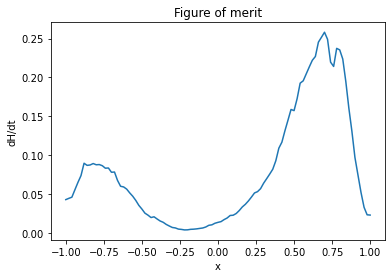

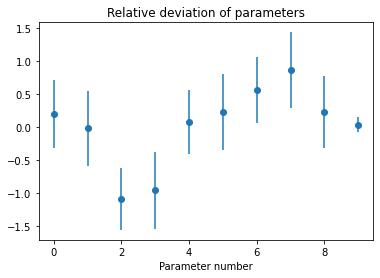

In [26]:
# 1. draw MCMC samples from previous fit
draw = fitter.state.draw(thin=500)
pts = draw.points

# 2. calculate y profiles corresponding to each sample
yprofs = sampler(problem, x, pts)

# plt y profiles with ground truth and data points, excluding the large-error initial points
plt.figure()
maxyprof = max(truey)
minyprof = min(truey)
for yprof in yprofs:
    plt.plot(x, yprof)
    maxyprof = max(maxyprof, max(yprof))
    minyprof = min(minyprof, min(yprof))

plt.plot(x, truey, linewidth=4, color='0.1')
plt.ylabel('y(x)')
plt.xlabel('x')
excludeidx = len(ix)
plt.errorbar(problem.fitness.x[excludeidx:], problem.fitness.y[excludeidx:], problem.fitness.dy[excludeidx:], fmt='o')
plt.ylim([minyprof, maxyprof])
plt.title(f'Iteration {iternum}')

# 3. Calculate and plot dH/dt
plt.figure()
plt.title('Figure of merit')
dHs, relsigs = dH(x, yprofs, pts, sel=None)
plt.plot(x, dHs)
plt.ylabel('dH/dt')
plt.xlabel('x')
print(f'Expected speed improvement factor: {np.max(dHs) / np.mean(dHs): 0.2f}')

# Calculate relative deviation of the parameters from their true values
plt.figure()
plt.title('Relative deviation of parameters')
vals = np.mean(pts, axis=0)-truepars
vals[-1] += 10.0
plt.errorbar(np.arange(npars), vals, np.std(pts, axis=0), fmt='o')
plt.xlabel('Parameter number')


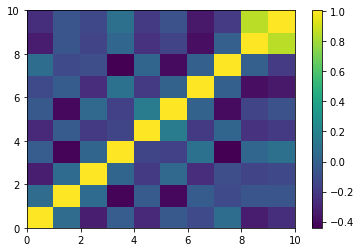

In [27]:
# Calculate and plot covariance matrix of the parameters
# This is actually a cross-correlation matrix as the individual variances are normalized out

plt.pcolor(np.cov(pts / np.std(pts, axis=0), rowvar=False))
plt.colorbar()

In [28]:
# 4. select new point at maximum of dH/dt
newx = x[np.where(dHs==np.max(dHs))[0]]

# probe dy / y at new measurement point
newdyoy = relsigs[np.where(dHs==np.max(dHs))[0]]
print(newx, newdyoy)

# 5. simulate new points. For speed, use aggressive measurement so that the 
# dy / y at each new point is reduced by a factor of 10 (normally this would not
# be done so aggressively, as efficiency is lost)
newy, newdy = new_points(newx, x, truey, dyoy=newdyoy/10.0)
datax.append(newx)
datay.append(newy)
datady.append(newdy)

# create updated fit model with new data
newmodely = Curve(poly, flatten(datax), flatten(datay), flatten(datady), p0=p[0], p1=p[1], p2=p[2], p3=p[3], p4=p[4], p5=p[5], p6=p[6], p7=p[7], p8=p[8], p9=p[9] + 10.)
problem = FitProblem(newmodely)


[0.7] [0.05550004]


In [29]:
# 6. refit
monitor = ConsoleMonitor(problem)

# Condition and run fit
fitter = DreamFit(problem)
result = fitter.solve(monitors=[monitor], **{'burn': 1000, 'steps': 500, 'pop': 10, 'alpha': 0.001})


# steps: 500, # draws: 50000
step 1 cost 6.6(23)
                                      p0 .|........   -0.71837 in (-1,1)
                                      p1 ...|......  -0.318465 in (-1,1)
                                      p2 .|........  -0.763449 in (-1,1)
                                      p3 ...|......   -0.37877 in (-1,1)
                                      p4 .........|   0.919323 in (-1,1)
                                      p5 .........|   0.912419 in (-1,1)
                                      p6 ...|......  -0.372179 in (-1,1)
                                      p7 ..|.......  -0.487957 in (-1,1)
                                      p8 |.........  -0.921232 in (-1,1)
                                      p9 |.........  -0.839363 in (-1,1)
step 47 cost 1.8(23)
step 96 cost 0.3(23)
step 132 cost 0.2(23)
step 172 cost 0.2(23)
step 209 cost 0.2(23)
step 244 cost 0.2(23)
step 280 cost 0.2(23)
step 313 cost 0.2(23)
step 353 cost 0.2(23)
step 387 cost 0.2(23)
ste